todo:
- smoothing: 5mm fwhm, determine brightness threshold from GM, WM, and outside brain signal.
- work around missing conditions (participant responses)
- detect outliers and add to design matrix. DONE.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os.path as op

import pandas as pd
import numpy as np
import nibabel as nib

from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_first_level_design_matrix
from nilearn.image import mean_img, concat_imgs, resample_to_img
from nilearn.masking import apply_mask

import enhance_censoring as ec

In [2]:
def calhoun_correction(can, temp, disp=None):
    use_img = False
    if isinstance(can, nib.Nifti1Image):
        use_img = True
        aff = can.affine
        can = can.get_data()
        temp = temp.get_data()
        if disp is not None:
            disp = disp.get_data()
    
    if disp is not None:
        out = np.sign(can) * np.sqrt((can ** 2) + (temp ** 2) + (disp ** 2))
    else:
        out = np.sign(can) * np.sqrt((can ** 2) + (temp ** 2))
    
    if use_img:
        out = nib.Nifti1Image(out, aff)
    
    return out

In [22]:
in_dir = '/scratch/kbott/narps/'
fp_dir = op.join(in_dir, 'derivatives/fmriprep/')
ev_dir = op.join(in_dir, 'event_tsvs')
#func_file = op.join(fp_dir,
#                    'sub-001_task-MGT_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
#ev_file = op.join(in_dir, 'event_tsvs/sub-001_task-MGT_run-01_events.tsv')
#cf_file = op.join(fp_dir, 'sub-001_task-MGT_run-01_bold_confounds.tsv')

subjects = sorted([op.basename(op.splitext(f)[0]) for f in
                   glob(op.join(in_dir, 'derivatives/fmriprep/*.html'))])
# sub = subjects[2]  # missing some conditions
sub = subjects[1]
sub_anat_dir = op.join(fp_dir, sub, 'anat')
sub_func_dir = op.join(fp_dir, sub, 'func')
func_files = sorted(glob(op.join(sub_func_dir, '*_task-MGT_*space-MNI152NLin2009cAsym_preproc.nii.gz')))
brainmask = sorted(glob(op.join(sub_func_dir, '*_task-MGT_*space-MNI152NLin2009cAsym_brainmask.nii.gz')))[0]
cf_files = sorted(glob(op.join(sub_func_dir, '*_task-MGT_*bold_confounds.tsv')))
assert len(func_files) == len(cf_files)
ev_files = sorted(glob(op.join(ev_dir, '{0}*.tsv'.format(sub))))
assert len(ev_files) == len(func_files)

gm_file = sorted(glob(op.join(sub_anat_dir, '*_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz')))[0]
wm_file = sorted(glob(op.join(sub_anat_dir, '*_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz')))[0]
gm_img = resample_to_img(gm_file, func_files[0], 'linear')
wm_img = resample_to_img(wm_file, func_files[0], 'linear')

gm_mask = gm_img.get_data()
gm_mask = (gm_mask > 0.5).astype(int)
gm_img = nib.Nifti1Image(gm_mask, gm_img.affine)
gm_data = apply_mask(func_files[0], gm_img)
mean_gm = np.mean(gm_data)

wm_mask = wm_img.get_data()
wm_mask = (wm_mask > 0.5).astype(int)
wm_img = nib.Nifti1Image(wm_mask, wm_img.affine)
wm_data = apply_mask(func_files[0], wm_img)
mean_wm = np.mean(wm_data)

mean_contrast = mean_gm - mean_wm

bm_img = nib.load(brainmask)
ob_data = bm_img.get_data()
ob_data = 1 - ob_data
ob_img = nib.Nifti1Image(ob_data, bm_img.affine)
ob_data = apply_mask(func_files[0], ob_img)
mean_noise = np.mean(ob_data)

brightness_threshold = np.mean((mean_contrast, mean_noise))
fwhm = 5


In [ ]:
from nipype.interfaces import fsl

sus = fsl.SUSAN()
sus.inputs.in_file = func_files[0]
sus.inputs.brightness_threshold = brightness_threshold
sus.inputs.fwhm = 5.0
sus.inputs.out_file = 'test.nii.gz'
sus.run()

In [38]:

print(brightness_threshold)

1619.0688


In [37]:
print()

1619.0688


In [24]:
gm_img_orig = nib.load(gm_file)
print(np.unique(gm_img_orig.get_data()))

[0.000000e+00 1.401298e-45 2.802597e-45 ... 9.607793e-01 9.608460e-01
 9.609028e-01]


In [4]:
fmri_img = [nib.load(func_file) for func_file in func_files]
affine, shape = fmri_img[0].affine, fmri_img[0].shape

In [5]:
img = nib.load(func_files[0])
n_vols = img.shape[-1]

# Don't worry, this *is* 1 sec. Not a header problem.
tr = img.header.get_zooms()[-1]

frame_times = np.arange(n_vols) * tr

# Create mean image for display
mean_image = mean_img(fmri_img)

In [6]:
hrf_model = 'spm + derivative + dispersion'
period_cut = 128.
drift_model = 'Cosine'
slice_time_ref = 0.

design_matrices = []
for idx, img in enumerate(fmri_img):
    # Don't worry, this *is* 1 sec. Not a header problem.
    tr = img.header.get_zooms()[-1]
    n_vols = img.shape[-1]
    frame_times = np.arange(n_vols) * tr
    
    # Load in confounds
    cf_df = pd.read_csv(cf_files[idx], sep='\t')
    fd = cf_df['FramewiseDisplacement'].values
    cens_vec = ec.censor(fd, 0.9, n_contig=1, n_before=1, n_after=2)
    cens_arr = ec._to_arr(cens_vec)

    # Build experimental paradigm
    ev_df = pd.read_csv(ev_files[idx], sep='\t')
    ev_df.loc[ev_df['RT'] == 0, 'RT'] = ev_df['duration']
    ev_df['duration'] = ev_df['RT']
    ev_df['trial_type'] = ev_df['participant_response']
    if idx == 0:
        count_df = ev_df.groupby('trial_type').count()
    else:
        count_df += ev_df.groupby('trial_type').count()

    ev_df_gain = ev_df.copy()
    #ev_df_loss = ev_df.copy()
    ev_df_gain['modulation'] = (ev_df['gain'] - ev_df['gain'].mean()) / ev_df['gain'].std()
    
    dm_pm = make_first_level_design_matrix(
        frame_times,
        ev_df_gain,
        hrf_model=hrf_model,
        period_cut=period_cut,
        drift_model=drift_model
        )
    cols = ev_df['participant_response'].unique()
    reg_cols = []
    for col in cols:
        reg_cols.append(col)
        reg_cols.append(col+'_derivative')
        reg_cols.append(col+'_dispersion')

    new_names = [col+'*gain' for col in reg_cols]

    # make main effect design matrix with modulators included
    dm = make_first_level_design_matrix(
        frame_times,
        ev_df,
        hrf_model=hrf_model,
        period_cut=period_cut,
        drift_model=drift_model,
        add_regs=dm_pm[reg_cols],
        add_reg_names=new_names
        )
    
    for i_vol in range(cens_arr.shape[1]):
        dm['censor_{0}'.format(i_vol)] = cens_arr[:, i_vol]
    
    sort_order = ['weakly', 'strongly', 'NoResp', 'drift', 'censor', 'constant']
    columns = [[c for c in dm.columns if c.startswith(so)] for so in sort_order]
    columns = [sorted(cols) for cols in columns]
    columns = [v for sl in columns for v in sl]
    dm = dm[columns]
    # make sure we didn't remove anything
    # print(dm.shape)

    # put the design matrices in a list
    design_matrices.append(dm)

prop_df = count_df['participant_response'][
    ['strongly_accept', 'weakly_accept', 'strongly_reject', 'weakly_reject']
]
prop_df /= prop_df.sum()

enhance_censoring.py:50: RuntimeWarning: invalid value encountered in greater_equal
  censor_vec = metric_arr >= metric_thresh
/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


In [7]:
contrasts = {
    'strongly_reject*gain': [],
    'strongly_reject_derivative*gain': [],
    'strongly_reject_dispersion*gain': [],
    'weakly_reject*gain': [],
    'weakly_reject_derivative*gain': [],
    'weakly_reject_dispersion*gain': [],
    'strongly_accept*gain': [],
    'strongly_accept_derivative*gain': [],
    'strongly_accept_dispersion*gain': [],
    'weakly_accept*gain': [],
    'weakly_accept_derivative*gain': [],
    'weakly_accept_dispersion*gain': [],
    }

for dm in design_matrices:
    contrast_matrix = np.eye(dm.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(dm.columns)])
    contrasts['strongly_reject*gain'].append(basic_contrasts['strongly_reject*gain'])
    contrasts['strongly_reject_derivative*gain'].append(basic_contrasts['strongly_reject_derivative*gain'])
    contrasts['strongly_reject_dispersion*gain'].append(basic_contrasts['strongly_reject_dispersion*gain'])
    contrasts['weakly_reject*gain'].append(basic_contrasts['weakly_reject*gain'])
    contrasts['weakly_reject_derivative*gain'].append(basic_contrasts['weakly_reject_derivative*gain'])
    contrasts['weakly_reject_dispersion*gain'].append(basic_contrasts['weakly_reject_dispersion*gain'])
    contrasts['strongly_accept*gain'].append(basic_contrasts['strongly_accept*gain'])
    contrasts['strongly_accept_derivative*gain'].append(basic_contrasts['strongly_accept_derivative*gain'])
    contrasts['strongly_accept_dispersion*gain'].append(basic_contrasts['strongly_accept_dispersion*gain'])
    contrasts['weakly_accept*gain'].append(basic_contrasts['weakly_accept*gain'])
    contrasts['weakly_accept_derivative*gain'].append(basic_contrasts['weakly_accept_derivative*gain'])
    contrasts['weakly_accept_dispersion*gain'].append(basic_contrasts['weakly_accept_dispersion*gain'])

In [8]:
from nistats.first_level_model import FirstLevelModel
print('Fitting a GLM')
fmri_glm = FirstLevelModel(t_r=tr, slice_time_ref=slice_time_ref,
                           hrf_model=hrf_model, drift_model=drift_model,
                           period_cut=period_cut, smoothing_fwhm=None,
                           mask=brainmask)
fitted_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)

Fitting a GLM


Computing contrasts
	contrast id: weakly_accept_derivative*gain


/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/nilearn/plotting/find_cuts.py:285: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data[slices] *= 1.e-3


	contrast id: strongly_accept_dispersion*gain
	contrast id: weakly_reject_derivative*gain
	contrast id: weakly_accept_dispersion*gain
	contrast id: strongly_accept_derivative*gain
	contrast id: weakly_reject_dispersion*gain
	contrast id: strongly_reject_derivative*gain
	contrast id: strongly_reject_dispersion*gain
	contrast id: weakly_accept*gain
	contrast id: strongly_accept*gain
	contrast id: strongly_reject*gain
	contrast id: weakly_reject*gain


/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


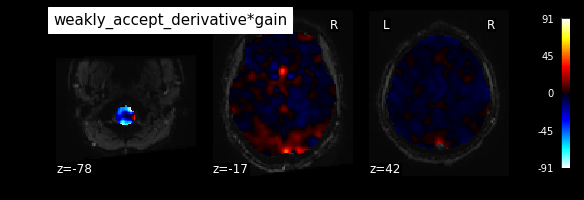

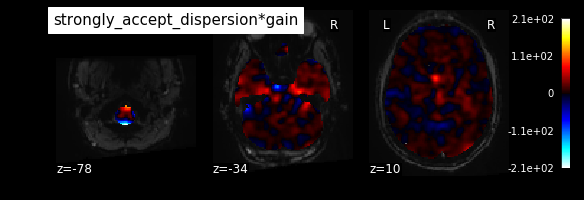

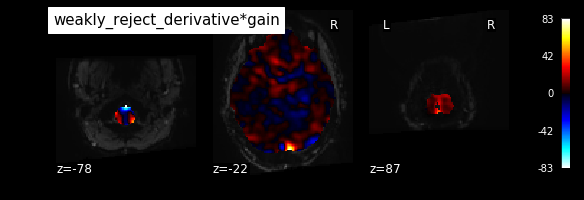

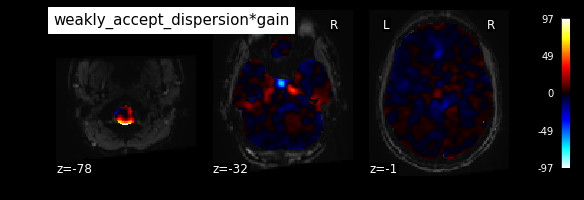

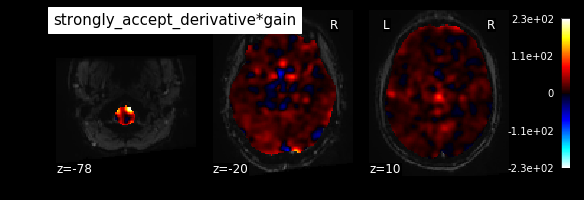

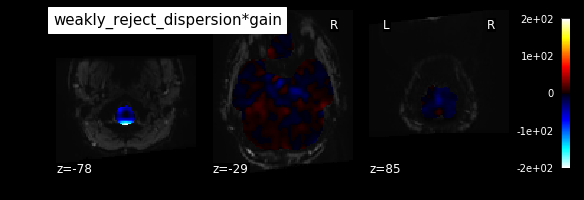

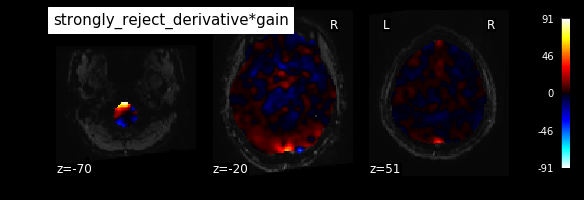

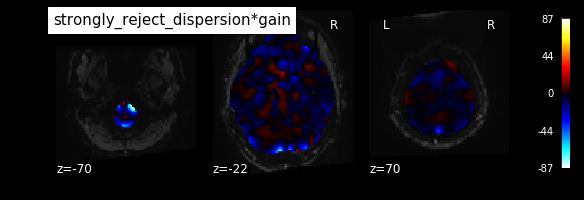

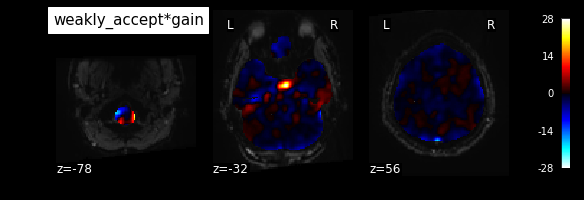

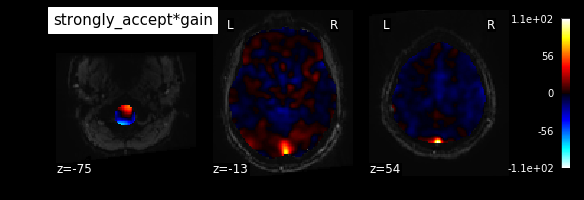

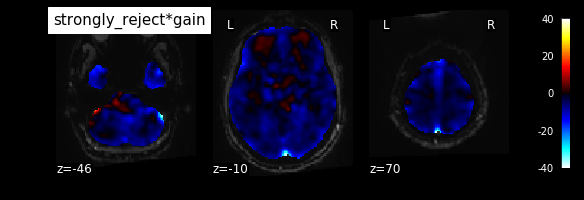

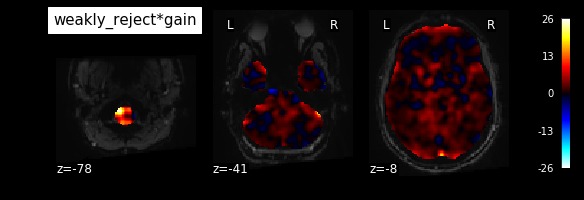

In [9]:
print('Computing contrasts')
from nilearn import plotting

beta_maps = {}

# Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
    print("\tcontrast id: %s" % contrast_id)
    # compute the contrasts
    beta_maps[contrast_id] = fmri_glm.compute_contrast(
        contrast_val, output_type='effect_size')
    # plot the contrasts as soon as they're generated
    # the display is overlayed on the mean fMRI image
    # a threshold of 3.0 is used. More sophisticated choices are possible.
    plotting.plot_stat_map(
        beta_maps[contrast_id], bg_img=mean_image, threshold=0.001, display_mode='z',
        cut_coords=3, black_bg=True, title=contrast_id)

In [10]:
strongly_accept_mag = calhoun_correction(
    beta_maps['strongly_accept*gain'],
    beta_maps['strongly_accept_derivative*gain'],
    beta_maps['strongly_accept_dispersion*gain'])
weakly_accept_mag = calhoun_correction(
    beta_maps['weakly_accept*gain'],
    beta_maps['weakly_accept_derivative*gain'],
    beta_maps['weakly_accept_dispersion*gain'])
weakly_reject_mag = calhoun_correction(
    beta_maps['weakly_reject*gain'],
    beta_maps['weakly_reject_derivative*gain'],
    beta_maps['weakly_reject_dispersion*gain'])
strongly_reject_mag = calhoun_correction(
    beta_maps['strongly_reject*gain'],
    beta_maps['strongly_reject_derivative*gain'],
    beta_maps['strongly_reject_dispersion*gain'])

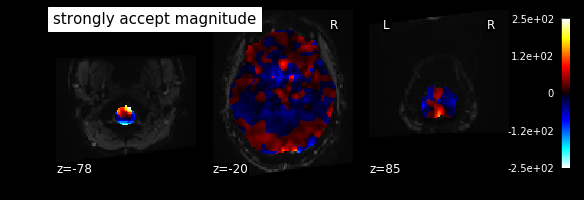

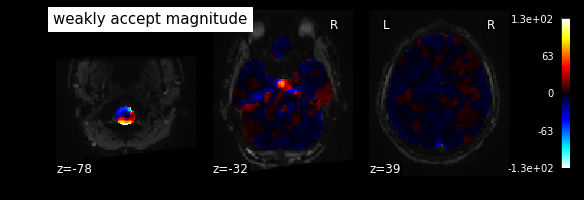

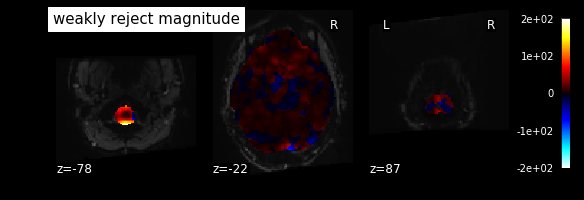

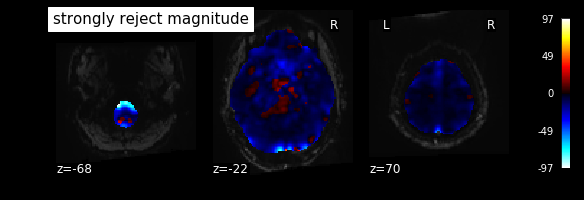

In [11]:
plotting.plot_stat_map(
    strongly_accept_mag, bg_img=mean_image, threshold=0.001, display_mode='z',
    cut_coords=3, black_bg=True, title='strongly accept magnitude')
plotting.plot_stat_map(
    weakly_accept_mag, bg_img=mean_image, threshold=0.001, display_mode='z',
    cut_coords=3, black_bg=True, title='weakly accept magnitude')
plotting.plot_stat_map(
    weakly_reject_mag, bg_img=mean_image, threshold=0.001, display_mode='z',
    cut_coords=3, black_bg=True, title='weakly reject magnitude')
plotting.plot_stat_map(
    strongly_reject_mag, bg_img=mean_image, threshold=0.001, display_mode='z',
    cut_coords=3, black_bg=True, title='strongly reject magnitude')

In [12]:
props = prop_df[['strongly_accept', 'weakly_accept', 'weakly_reject', 'strongly_reject']].values
aff = strongly_accept_mag.affine
imgs = [strongly_accept_mag, weakly_accept_mag, weakly_reject_mag, strongly_reject_mag]
data = [img.get_data() for img in imgs]

In [13]:
data_avg = np.average(np.stack(data, -1), axis=3, weights=props)

In [14]:
img_avg = nib.Nifti1Image(data_avg, aff)

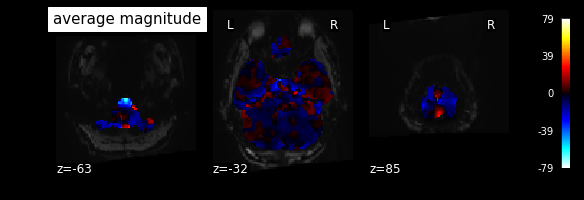

In [15]:
plotting.plot_stat_map(
    img_avg, bg_img=mean_image, threshold=0.001, display_mode='z',
    cut_coords=3, black_bg=True, title='average magnitude')

/home/data/nbc/data-analysis/env/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


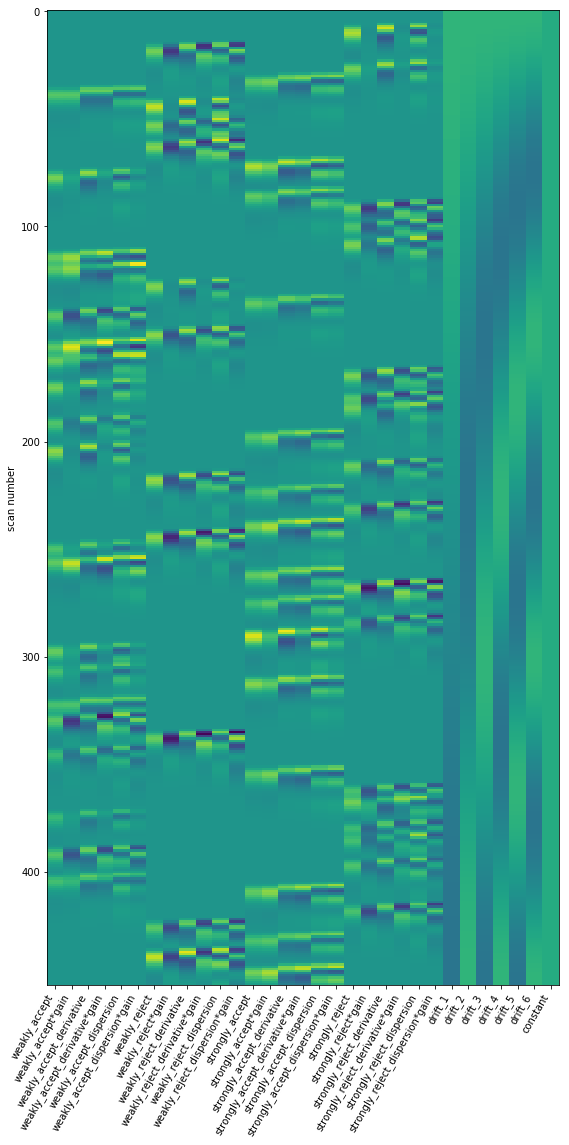

In [16]:
fig, ax = plt.subplots(figsize=(8, 16))
plot_design_matrix(design_matrices[2], ax=ax)
fig.show()